In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.font_manager
import seaborn as sns
import cartopy.io.shapereader as shpreader
import geopandas as gpd

In [2]:
models = ['ICHEC','CNRM','MPI']
model = 'ICHEC'
cap_output_csv = 'data/cap_share_all_periods_model_{}.csv'.format(model)
cap_input_generators_csv =  'data/cap_factor_input_all_periods_{}.csv'.format(model)
cap_input_per_carrier_csv = 'data/cap_factor_input_per_carrier_all_periods_{}.csv'.format(model)
cap_output = pd.read_csv(cap_output_csv, index_col=0)
cap_input_per_carrier = pd.read_csv(cap_input_per_carrier_csv, index_col=0)
cap_input_per_generator = pd.read_csv(cap_input_generators_csv, index_col=0)
# convert column names to multiindex
col_name_as_tuples = [(col_name.split('\'')[1],col_name.split('\'')[3]) for col_name in cap_input_per_generator.columns]
cap_input_per_generator.columns = pd.MultiIndex.from_tuples(col_name_as_tuples)


## Scatter plots capacity factors (input) vs. capacity share (output)  
- carrier $c = $ \[ 'offwind', 'onwind', 'solar', 'ror' \]
- Generators of carrier $c$: $G_c$
- Timesteps of considered period: $T$
- Number of timesteps: $N_T$
- Number of generators of carrier $c$: $N_{G_c}$

### Average Capacity Factor Of Carrier $c$ Input
\begin{equation}
    cap_{c,ave} = \frac{\sum_{t\in T}\sum_{g \in G_c} P_{g,max,pu,T}}{N_T N_{G_c}}
\end{equation}
<!-- (network.generators_t.p_max_pu.groupby(network.generators.carrier, axis=1).sum().sum()/ -->
<!--                                            (n_timesteps*n_generators_per_carrier)) -->
### Capacity Share Of Carrier $c$ from LOPF Output

\begin{equation}
    cap_{c,share} = \sum_{g \in G_c} P_{g,nom,opt}
\end{equation}
<!-- network.generators.p_nom_opt.groupby(network.generators.carrier).sum() -->

Each dot represents single period of a model

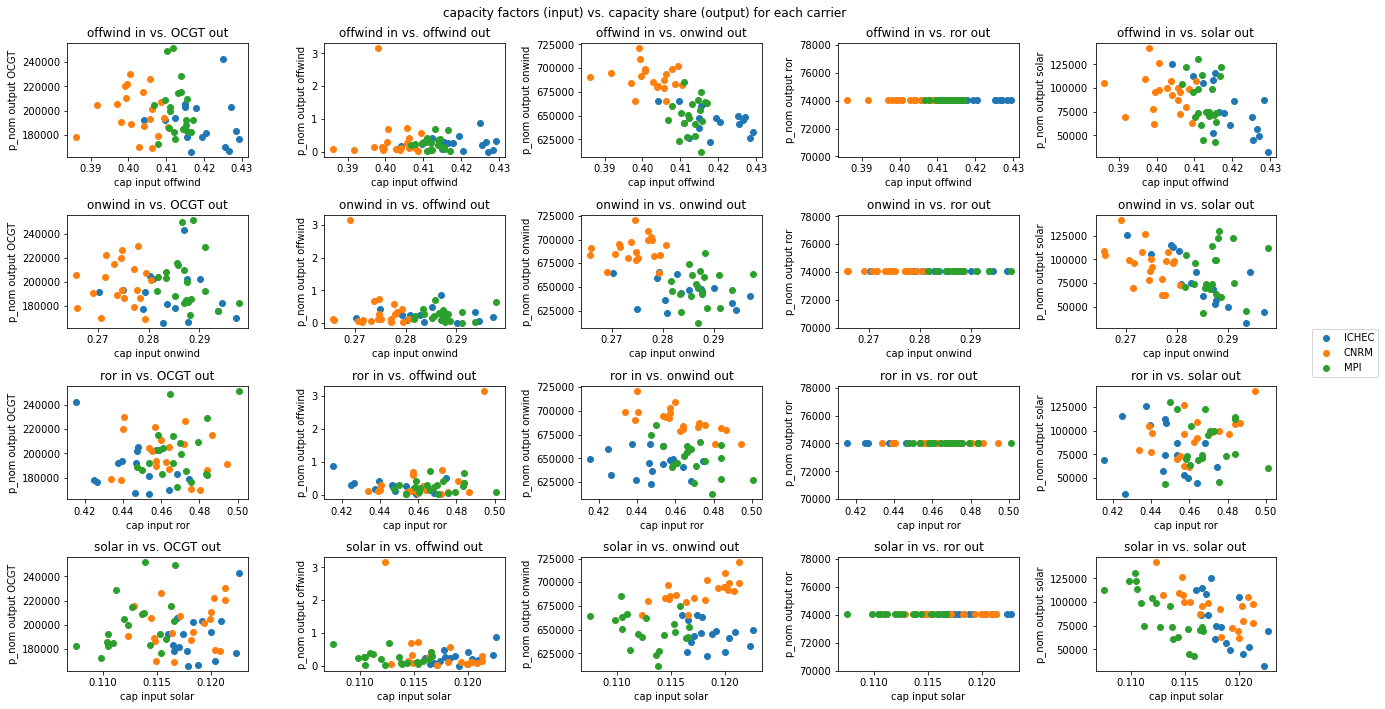

In [3]:
n_rows = 4#len(cap_input_per_carrier.index)
n_cols = 5#len(cap_output.index)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,10))
common_df = None
for model in models:
    # get input capacity factors
    cap_input_per_carrier_csv = 'data/cap_factor_input_per_carrier_all_periods_{}.csv'.format(model)
    cap_input_per_carrier = pd.read_csv(cap_input_per_carrier_csv, index_col=0)
    # get optimal nominal power of simulation
    cap_output_csv = 'data/cap_share_all_periods_model_{}.csv'.format(model)
    cap_output = pd.read_csv(cap_output_csv, index_col=0)
    if model== 'CNRM':
        cap_input_per_carrier.drop(axis=1, columns='2006-2012', inplace=True)
        cap_output.drop(axis=1, columns='2006-2012', inplace=True)
    if common_df is None:
        common_df = pd.concat([cap_input_per_carrier.T,  cap_output.T], axis=1, ignore_index=False)
    else:
        df_tmp = pd.concat([cap_input_per_carrier.T,  cap_output.T], axis=1, ignore_index=False)
        common_df = pd.concat([common_df, df_tmp], axis=0, ignore_index=True)
        
    for i, idx in enumerate(cap_input_per_carrier.index):
        for j, idx2 in enumerate(cap_output.index):
            ax = axes[i,j]
            ax.scatter(cap_input_per_carrier.loc[idx].values, cap_output.loc[idx2].values, label=model)
            ax.set_xlabel("cap input {}".format(idx))
            ax.set_ylabel("p_nom output {}".format(idx2))
            ax.set_title("{} in vs. {} out".format(idx, idx2))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, .5))
fig.suptitle("capacity factors (input) vs. capacity share (output) for each carrier")
fig.tight_layout()
fig.show()


In [4]:
col_names = [idx for idx in cap_input_per_carrier.index]
col_names += ['{}_out'.format(idx) for idx in cap_output.index]
col_names
common_df.columns = col_names
common_df.head()

,offwind,onwind,ror,solar,OCGT_out,offwind_out,onwind_out,ror_out,solar_out
0,0.429303,0.293586,0.426577,0.122289,176424.428178,0.342132,632717.218671,74054.075094,32872.675595
1,0.425398,0.297239,0.464089,0.120329,170139.785216,0.202156,640892.865839,74054.075094,44860.887016
2,0.425090,0.287030,0.415289,0.122619,242774.877477,0.872763,649242.016491,74054.075094,69136.334538
3,0.415001,0.287486,0.457367,0.120933,202891.363999,0.172782,647877.149723,74054.075094,52880.764622
4,NaN,NaN,NaN,NaN,172634.180038,0.053154,639847.355807,74054.075094,59486.601566


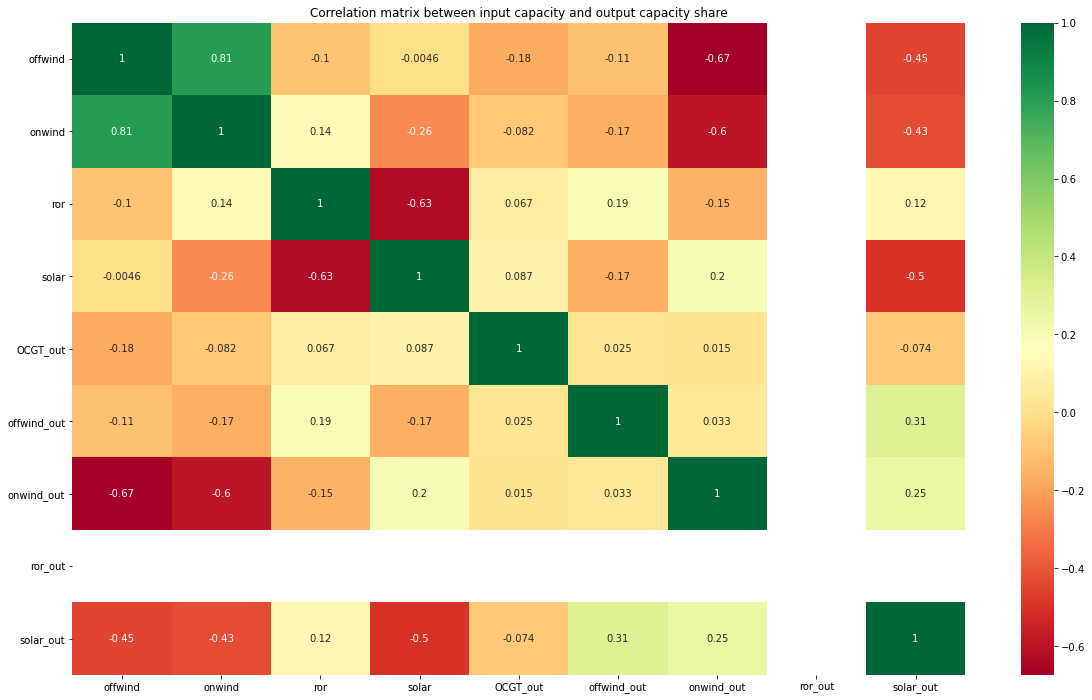

In [5]:
corr_df = common_df.corr(method='pearson')
plt.figure(figsize=(20, 12))
sns.heatmap(corr_df, annot=True, cmap="RdYlGn")
plt.yticks(rotation=0) 
plt.title("Correlation matrix between input capacity and output capacity share")
plt.show()

## Spatial resolution per carrier

In [6]:
cap_input_per_carrier_dict = {}
p_nom_per_carrier_dict = {}
cap_factor_per_carrier_and_node_dict = {}
p_t_per_carrier_and_node_dict = {}
for i, model in enumerate(models):
    cap_input_per_carrier_dict[model] = pd.read_csv('data/cap_factor_input_per_carrier_all_periods_{}.csv'.format(model), index_col=0)

    p_nom_per_carrier_dict[model] = pd.read_csv('data/cap_share_all_periods_model_{}.csv'.format(model), index_col=0)

    cap_factor_per_carrier_and_node_dict[model] = pd.read_csv('data/cap_factor_input_per_carrier_and_node_all_periods_{}.csv'.format(model), index_col=[0,1])

    p_t_per_carrier_and_node_dict[model] = pd.read_csv('data/gen_share_per_node_all_periods_model_{}.csv'.format(model), index_col=[0,1])

In [88]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = ['c', 'm', 'y', 'k', 'r', 'b']#prop_cycle.by_key()['color']
linestyles=['-', '--', ':', '-.']
style_dict = {c: (colors[i % len(colors)] + linestyles[i//len(colors) % len(linestyles)]) for i, c in enumerate(countries)}

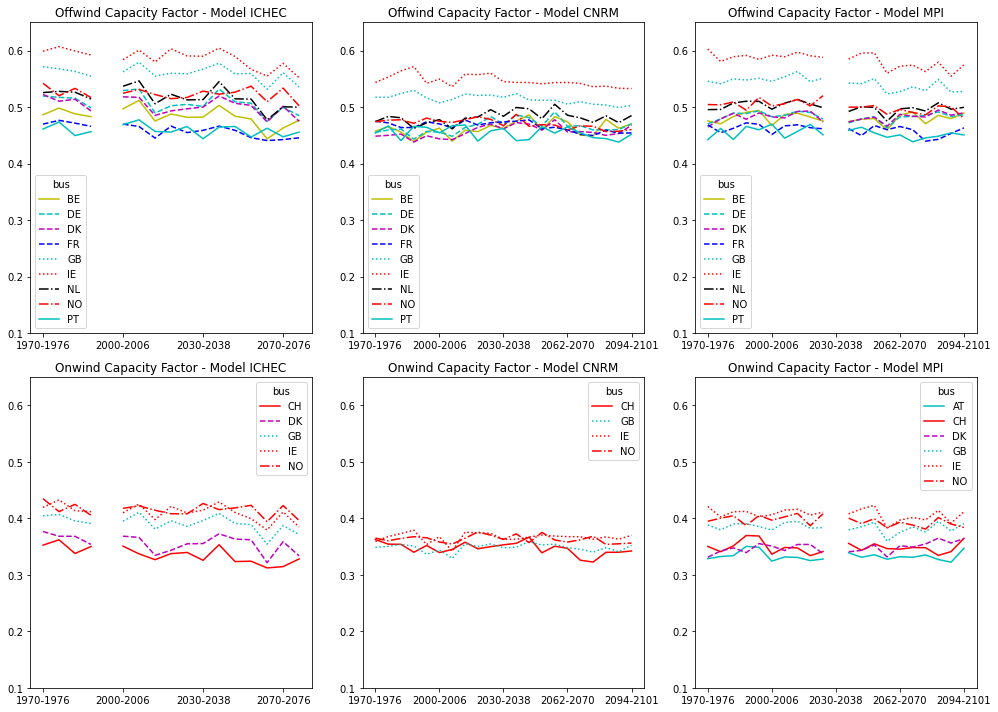

In [116]:
model = 'CNRM'
fig, axes = plt.subplots(2,3, figsize=(14,10))
threshold_off = 0.45
threshold_on = 0.33
legend=True
for i, model in enumerate(models):
    cap_input_per_carrier = pd.read_csv('data/cap_factor_input_per_carrier_all_periods_{}.csv'.format(model), index_col=0)

    p_nom_per_carrier = pd.read_csv('data/cap_share_all_periods_model_{}.csv'.format(model), index_col=0)

    cap_factor_per_carrier_and_node = pd.read_csv('data/cap_factor_input_per_carrier_and_node_all_periods_{}.csv'.format(model), index_col=[0,1])

    p_t_per_carrier_and_node = pd.read_csv('data/gen_share_per_node_all_periods_model_{}.csv'.format(model), index_col=[0,1])
    df_offwind = cap_factor_per_carrier_and_node.xs('offwind', axis=0, level=1)
    df_onwind = cap_factor_per_carrier_and_node.xs('onwind', axis=0, level=1)
    df_offwind = df_offwind[df_offwind.mean(axis=1)>threshold_off]
    df_onwind = df_onwind[df_onwind.mean(axis=1)>threshold_on]
    style_offwind = [style_dict[idx] for idx in df_offwind.index]
    style_onwind = [style_dict[idx] for idx in df_onwind.index]

    df_offwind.T.plot(legend=legend, ax=axes[0,i], style=style_offwind)
    df_onwind.T.plot(legend=legend, ax=axes[1,i], style=style_onwind)
    axes[0,i].set_title("Offwind Capacity Factor - Model {}".format(model))
    axes[0,i].set_ylim([0.1,0.65])
    axes[1,i].set_title("Onwind Capacity Factor - Model {}".format(model))
    axes[1,i].set_ylim([0.1,0.65])
# handles, labels = axes[1,i].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, .5))
fig.tight_layout()
fig.show()

In [47]:
cap_input_per_carrier_dict['CNRM'].max(axis=1)
model = 'CNRM'
cap_factor_per_carrier_and_node = pd.read_csv('data/cap_factor_input_per_carrier_and_node_all_periods_{}.csv'.format(model), index_col=[0,1])
df = pd.DataFrame(columns=['bus', 'model'])

for m in models:
    for carrier in ['offwind', 'onwind']:
#     carrier = 'offwind'
        cap_factor_per_carrier_and_node = pd.read_csv('data/cap_factor_input_per_carrier_and_node_all_periods_{}.csv'.format(model), index_col=[0,1])
        countries = cap_factor_per_carrier_and_node.xs(carrier, axis=0, level=1).index

        df_tmp = pd.DataFrame(columns=['bus', 'model'])
        df_tmp['bus'] = countries
        df_tmp['model'] = len(countries) * [m]
        df_tmp['carrier'] = len(countries) * [carrier]
        df_tmp['cap_mean'] = cap_factor_per_carrier_and_node.xs(carrier, axis=0, level=1).mean(axis=1).values
        df_tmp['cap_max'] = cap_factor_per_carrier_and_node.xs(carrier, axis=0, level=1).max(axis=1).values
        df_tmp['cap_min'] = cap_factor_per_carrier_and_node.xs(carrier, axis=0, level=1).min(axis=1).values
        df = pd.concat([df, df_tmp], ignore_index=True)

    
#     cap_factor_per_carrier_and_node = pd.read_csv('data/cap_factor_input_per_carrier_and_node_all_periods_{}.csv'.format(model), index_col=[0,1])
    
df


,bus,model,carrier,cap_mean,cap_max,cap_min
0,BA,ICHEC,offwind,0.248893,0.264882,0.232514
1,BE,ICHEC,offwind,0.462515,0.486424,0.439378
2,BG,ICHEC,offwind,0.337859,0.354916,0.316618
3,DE,ICHEC,offwind,0.465611,0.491827,0.443491
4,DK,ICHEC,offwind,0.456863,0.477875,0.438313
...,...,...,...,...,...,...
154,RO,MPI,onwind,0.209305,0.216788,0.194073
155,RS,MPI,onwind,0.229440,0.244601,0.213131
156,SE,MPI,onwind,0.280390,0.293137,0.267689
157,SI,MPI,onwind,0.235152,0.250400,0.217852


In [112]:
def plot_cap_vs_p_t_per_country(cap_factor_per_carrier_and_node_dict, p_t_per_carrier_and_node_dict, cap_carrier, g_carrier):
    n_rows = 6
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,10))
#     cap_carrier = 'offwind'
#     g_carrier = 'offwind'
    for model in models:
    #     cap_input_per_carrier = cap_input_per_carrier_dict[model]
    #     p_nom_per_carrier = p_nom_per_carrier_dict[model]
        cap_factor_per_carrier_and_node = cap_factor_per_carrier_and_node_dict[model]
        p_t_per_carrier_and_node = p_t_per_carrier_and_node_dict[model]
        countries = p_t_per_carrier_and_node.xs('offwind', axis=0, level=1).index

        for i,c in enumerate(countries):
            i_row = i // n_cols
            i_col = i % n_cols

            axes[i_row, i_col].scatter(cap_factor_per_carrier_and_node.xs(cap_carrier, axis=0, level=1).loc[c],
                                       p_t_per_carrier_and_node.xs(g_carrier, axis=0, level=1).loc[c], label=model)
            axes[i_row, i_col].set_ylabel("p_t {}".format(g_carrier))
            axes[i_row, i_col].set_xlabel("cap factor {}".format(cap_carrier))
            axes[i_row, i_col].set_title("{}".format(c))

    handles, labels = axes[1,1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, .5))
    fig.suptitle("Cap factor of {} vs generation share of {} for each country".format(cap_carrier, g_carrier))
    fig.tight_layout()
    fig.show()

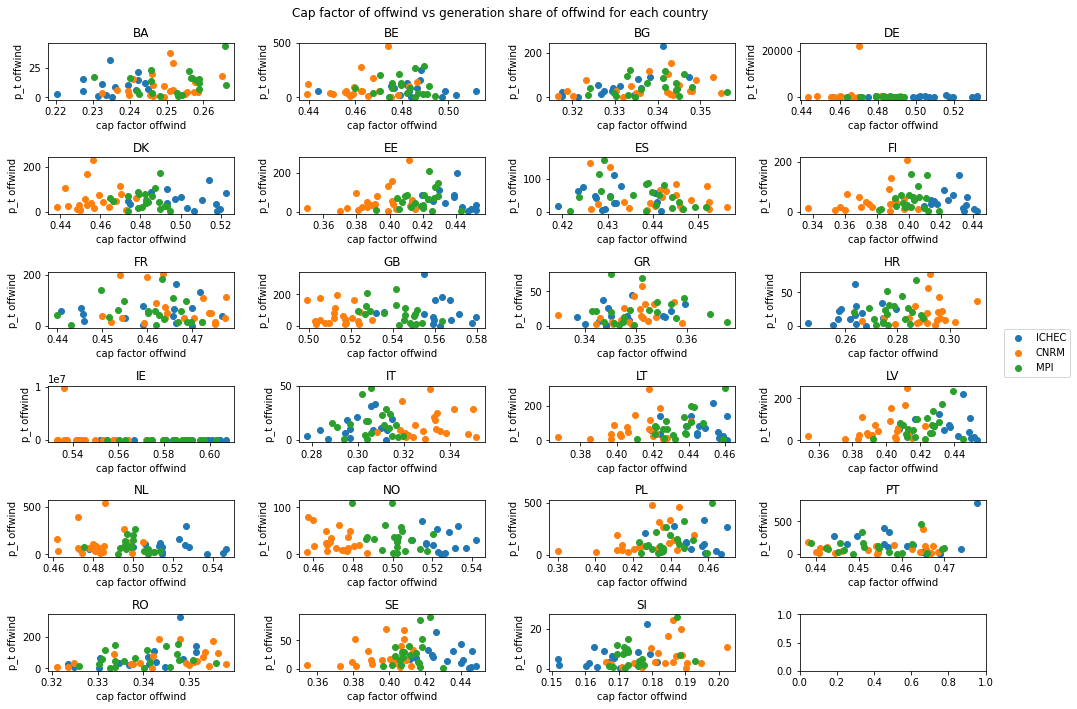

In [113]:
plot_cap_vs_p_t_per_country(cap_factor_per_carrier_and_node_dict, p_t_per_carrier_and_node_dict, cap_carrier='offwind', g_carrier='offwind')

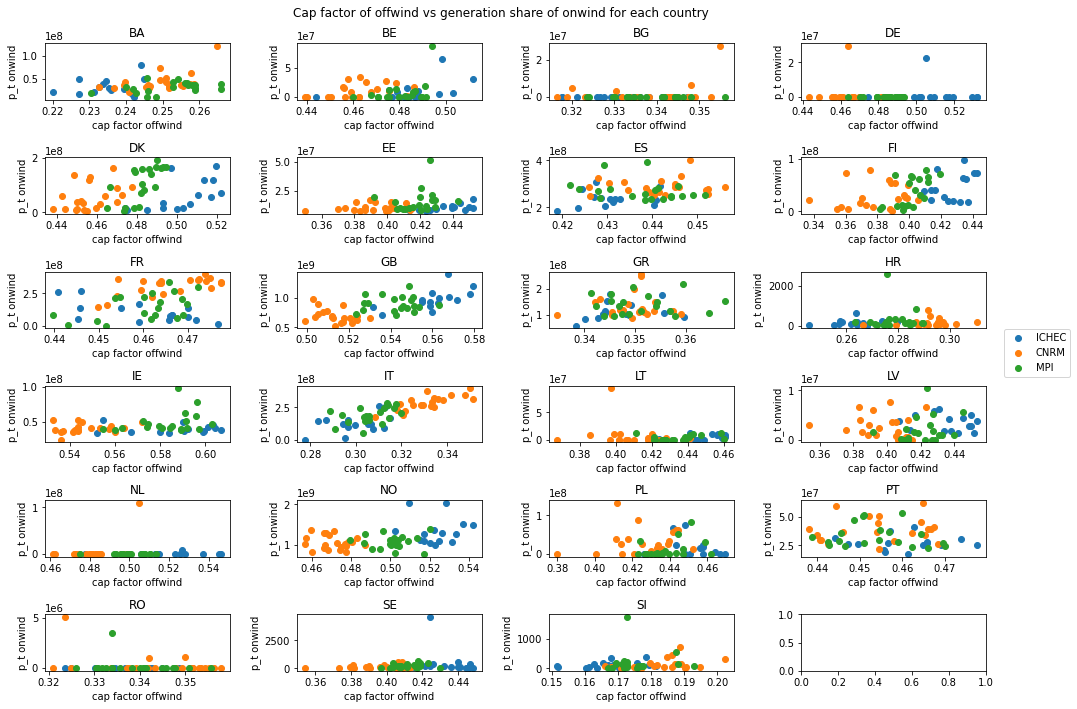

In [114]:
plot_cap_vs_p_t_per_country(cap_factor_per_carrier_and_node_dict, p_t_per_carrier_and_node_dict, cap_carrier='offwind', g_carrier='onwind')

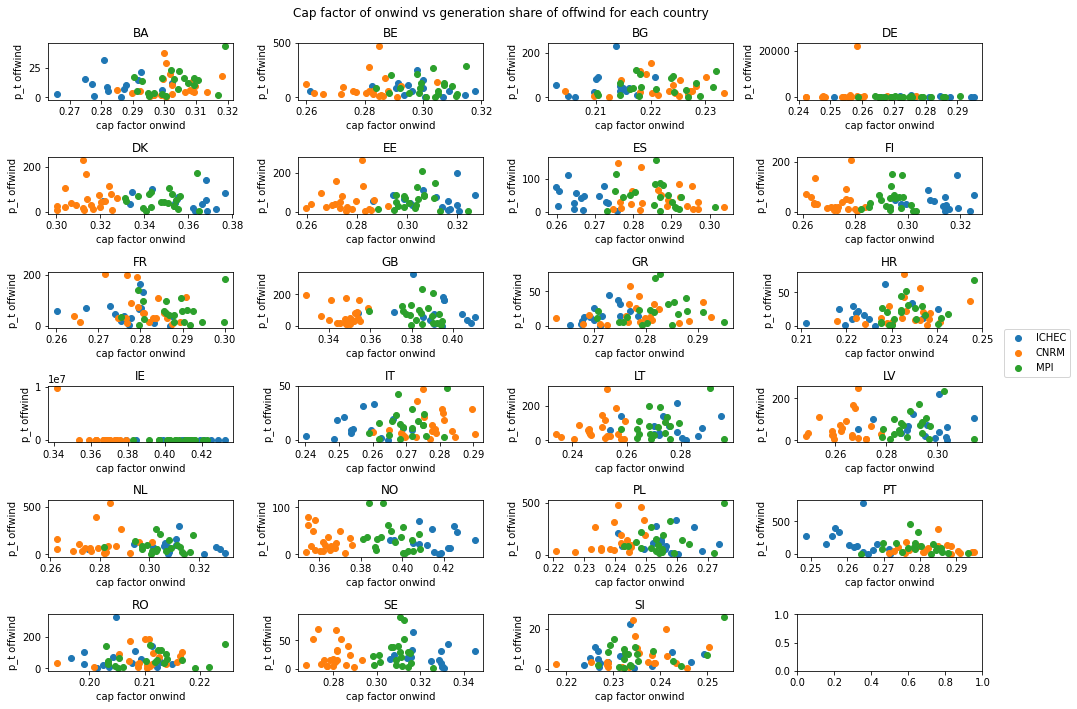

In [115]:
plot_cap_vs_p_t_per_country(cap_factor_per_carrier_and_node_dict, p_t_per_carrier_and_node_dict, cap_carrier='onwind', g_carrier='offwind')

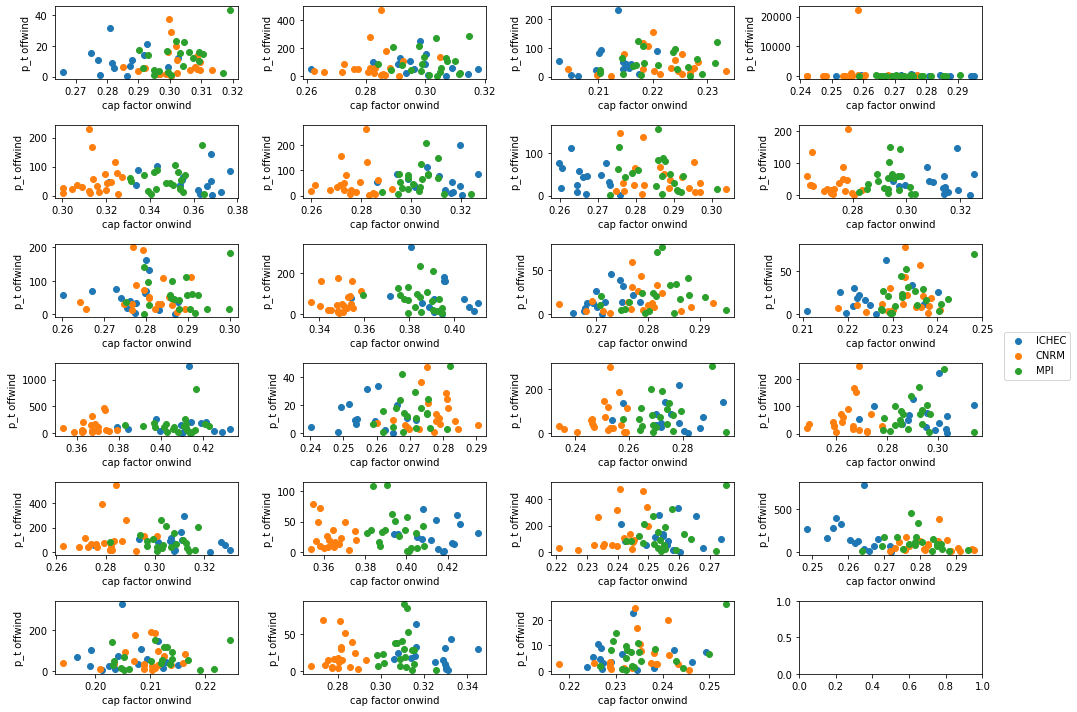

In [231]:
countries = p_t_per_carrier_and_node.xs('offwind', axis=0, level=1).index
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,10))
cap_carrier = 'onwind'
g_carrier = 'offwind'
for model in models:
    for i,c in enumerate(countries):
        i_row = i // n_cols
        i_col = i % n_cols
        cap_input_per_carrier = cap_input_per_carrier_dict[model]
        p_nom_per_carrier = p_nom_per_carrier_dict[model]
        cap_factor_per_carrier_and_node = cap_factor_per_carrier_and_node_dict[model]
        p_t_per_carrier_and_node = p_t_per_carrier_and_node_dict[model]
        
        axes[i_row, i_col].scatter(cap_factor_per_carrier_and_node.xs(cap_carrier, axis=0, level=1).loc[c],
                                   p_t_per_carrier_and_node.xs(g_carrier, axis=0, level=1).loc[c], label=model)
        axes[i_row, i_col].set_ylabel("p_t {}".format(g_carrier))
        axes[i_row, i_col].set_xlabel("cap factor {}".format(cap_carrier))

handles, labels = axes[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, .5))
fig.tight_layout()

In [234]:
p_nom_per_carrier.loc['solar']

1970-1976     69194.354907
1976-1982     73607.119301
1982-1988     70019.650399
1988-1994     60756.152035
1994-2000     45619.293935
2000-2006     43523.712494
2006-2012     63601.858568
2012-2018     73688.598161
2018-2024     71297.545267
2024-2030     95663.045653
2030-2038              NaN
2038-2044     99429.278720
2044-2050     74199.914555
2050-2056     75186.279776
2056-2062    104639.172679
2062-2070     99421.577014
2070-2076    114015.095320
2076-2082    122567.198513
2082-2088    122446.313468
2088-2094    130387.575706
2094-2101    112445.301639
Name: solar, dtype: float64

<AxesSubplot:>

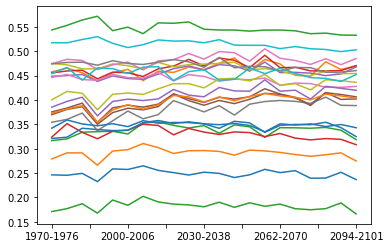

In [188]:
model = 'CNRM'
fig, axes = plt.subplots(2,3, figsize=(14,10))
for i, model in enumerate(models):
    cap_input_per_carrier = pd.read_csv('data/cap_factor_input_per_carrier_all_periods_{}.csv'.format(model), index_col=0)

    p_nom_per_carrier = pd.read_csv('data/cap_share_all_periods_model_{}.csv'.format(model), index_col=0)

    cap_factor_per_carrier_and_node = pd.read_csv('data/cap_factor_input_per_carrier_and_node_all_periods_{}.csv'.format(model), index_col=[0,1])

    p_t_per_carrier_and_node = pd.read_csv('data/gen_share_per_node_all_periods_model_{}.csv'.format(model), index_col=[0,1])
    cap_factor_per_carrier_and_node.xs('offwind', axis=0, level=1).T.plot(legend=False, ax=axes[0,i])
    cap_factor_per_carrier_and_node.xs('onwind', axis=0, level=1).T.plot(legend=False, ax=axes[1,i])
    axes[0,i].set_title("Offwind Capacity Factor - Model {}".format(model))
    axes[0,i].set_ylim([0.1,0.65])
    axes[1,i].set_title("Onwind Capacity Factor - Model {}".format(model))
    axes[1,i].set_ylim([0.1,0.5])
handles, labels = axes[1,i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, .5))
fig.tight_layout()
fig.show()


In [105]:
import pickle as pkl

In [107]:
with open('python/networks_per_period_ICHEC.pkl', 'rb') as f:
    network_all_periods_ICHEC = pkl.load(f)

In [112]:
periods = network_all_periods_ICHEC.keys()
